# Performing medical imaging segmentation like a pro (Part 2)
*A highly oppiniated and biased tutorial on MRI lesion segmentation using Pytorch*

**Sergi Valverde, PhD**
*Universitat de Girona, Spain*



# Introduction:

---

During this part of the tutorial, we will focus entirely on MRI image segmentation using the U-NET architecture. This second part is structured as follows:

1. The U-NET model
2. Data preparation
3. Training the network
4. Inference
5. Evaluation
6. Conclusion

First of all, import or install all necessary libraries. We will make use of [ANTS](https://github.com/ANTsX/ANTsPy), which is like a super-power to manage and process `nifti` images. 


In [1]:
# !pip install https://github.com/ANTsX/ANTsPy/releases/download/v0.2.0/antspyx-0.2.0-cp37-cp37m-linux_x86_64.whl
# !pip install statsmodels
import os
import random
import torch
import ants
import numpy as np

%load_ext autoreload
%autoreload 2

# 1. The U-NET model: 
---

Let's now introduce the U-NET model. The encoder-decoder U-NET model was proposed by [Ronneberger et al. 2015](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/) in the context of biomedical image segmentation (microscopy imaging). Encoder-decoder models are very similar to [autoencoders](https://en.wikipedia.org/wiki/Autoencoder), so the encoding part compresses the input image into the latent space, meaning that we end up with a very efficient compressed version of the image with a lot less information (feauture space? 🤔). 

Based on the latent space, the decoder part reconstructs the image back. Compared to other encoder-decoder architectures like the [SegNET](https://mi.eng.cam.ac.uk/projects/segnet/), the U-NET model introduced the copy and crop elements, so activations for each of the encoder layers were concatenated (or added) to the same level decoding layers in order to help to reconstruct the image structure prior to segmentation. 

<img src="https://miro.medium.com/max/2640/1*J3t2b65ufsl1x6caf6GiBA.png" width="600" height="600" />

Although the original U-NET was proposed for 2D images, very rapidly 3D implementations arised [Çiçek et al. 2016](https://arxiv.org/abs/1606.06650). However, dealing with entire MRI volumes is not always possible, due to hardware memory limitations, etc... So, in most cases, patch-wise implementations of the same 3D models are used for different tasks such as brain tissue segmentation [Bernal et al. 2019](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8754679). For our problem in hand, we are going to follow the same 3D patch-wise approach. 

Let's now define our first patch-wise `Unet` model in PyTorch:

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Unet(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size):

        super(Unet, self).__init__()

        # conv1 down
        self.conv1 = nn.Conv3d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv3d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # conv4 down (latent space)
        self.conv4 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv6 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # conv8 (classification)
        self.conv8 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1p = self.pool1(x1)
        x2 = F.relu(self.conv2(x1p))
        x2p = self.pool2(x2)
        x3 = F.relu(self.conv3(x2p))
        x3p = self.pool3(x3)
        
        # latent space
        x4 = F.relu(self.conv4(x3p))

        # decoder
        up1 = self.up1(x4)
        x5 = F.relu(self.conv5(up1 + x3)) # look how layers are added :o
        up2 = self.up2(x5)
        x6 = F.relu(self.conv6(up2 + x2))
        up3 = self.up3(x6)
        x7 = F.relu(self.conv7(up3 + x1))
        
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv8(x7), dim=1) 
        return out

# 2. Data preparation:
---

Let's now obtain some data to train and test the model. Download the MRI scans and move it to `data`:

In [ ]:
!mkdir data

In [ ]:
%%capture
!wget https://www.dropbox.com/s/cfhcbkxlu23nzi9/WMH2017_set.zip?dl=0 
!unzip WMH2017_set.zip\?dl\=0
!mv WMH2017 data/

We have stored a reduced set of the [MICCAI2017 WM Hyperintensity challenge](https://wmh.isi.uu.nl) at `data/WMH2017` and split it in two sets containing 20 training and 10 testing cases. Each case contains a `FLAIR` and a `T1` image, co-registered to the `FLAIR` space (3mm). Manual annotated masks for white matter intensities are also provided for each case. Manual annotations include white matter lesions `class=1` and other pathologies `class=2` (which are ignored). Let's see a case as example: 

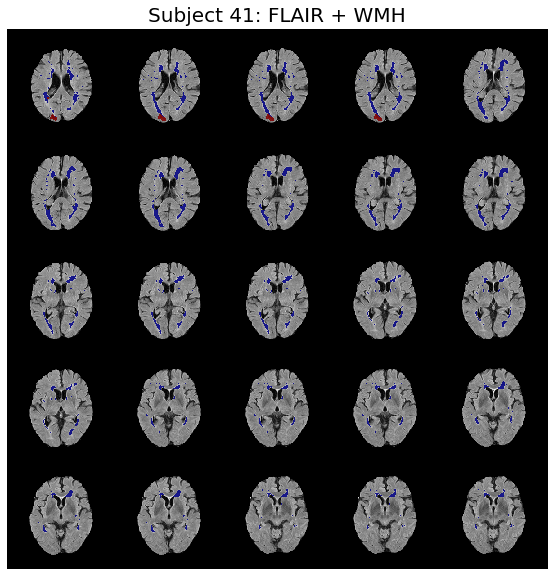

In [94]:
mri_subject = ants.image_read('data/WMH2017/train/41/FLAIR_brain.nii.gz')
lesion_mask = ants.image_read('data/WMH2017/train/41/wmh.nii.gz')
mri_subject.plot(overlay=lesion_mask, nslices=25, axis=2, title='Subject 41: FLAIR + WMH')

## 2.1 Loading data efficiently:

Similar to other *Deep Learning* toolkits, Pytorch also incorporates some objects to deal with data efficiently. In particular, we will make use of `Datasets` and `Dataloaders`:

* `Datasets` objects are used to build customs datasets from our data, permitting us to manage training data very efficiently. For instance, imagine a custom dataset with hundreds of MRI subjects containing several input modalities. Loading and managing this amount of information may be tricky in some situations, so a custom `Dataset` that loads the data when necessary is convenient. 


* `Dataloaders` take `Datasets` as input and permits to automatically collate individual fetched data samples into batches via arguments. `Dataloaders` yield consecutive batch samples during the training loop, handling all the data requirements via the `Dataset` object. 

In order to speed up this tutorial, we are going to make use of some helper funcions to deal with MRI data and convert them into PyTorch `dataloaders` (see `utils.py` for more information). 


Let's now train our `Unet` model using the `WMH2017` data. Before start training, several steps have to be taken into account: 
1. Split the available data into training, validation and test sets. 
2. Build the proper training data structures using the PyTorch `Dataset` and `Dataloader` objects.
3. Build the training loop. 

With the aim  to unify all the hyper-parameters and training options, we will define a dictionary `options` that we will populate with new values: 

In [3]:
options = {}

# training data path
options['training_path'] = 'data/WMH2017/train'

# testing data path 
options['test_path'] = 'data/WMH2017/test'

# train/validation split percentage
options['train_split']  = 0.3

# input modality names
options['input_data'] = ['FLAIR_brain.nii.gz', 'T1_brain.nii.gz']

# ground-truth name
options['gt_data'] = 'wmh.nii.gz'

## 2.2 Training generators: 

We are going to use the helper class `MRI_DataPatchLoader` from `utils.py` to generate a `Dataset` object based on our data. `MRI_DataPathLoader` requires an input dictionary with all image paths, image labels, and some other options for patch generation and normalization that we will cover in a few minutes. 

Additionally, the `MRI_DataPathLoader` also requires a third dictionary containing the paths a ROI mask from within the patch sampling should be performed. This mask is very handful to guide the sampling process, for instance to remove background voxels, deal with class imbalance etc...

For our example, let's generate a ROI mask for each subject simply with the binary brain mask:

In [4]:
options['roi'] = 'brainmask.nii.gz'

def mask_image(im):
    return (im > 0).astype('float32')

for scan_id in os.listdir(options['training_path']):
    scan = ants.image_read(os.path.join(options['training_path'], 
                                        scan_id, 
                                        'FLAIR_brain.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['training_path'], 
                                       scan_id, 
                                       options['roi']))
                                       
for scan_id in os.listdir(options['test_path']):
    scan = ants.image_read(os.path.join(options['test_path'], 
                                        scan_id, 
                                        'FLAIR_brain.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['test_path'], 
                                       scan_id, 
                                       options['roi']))
                                       

Now, we can define the input dictionaries for training and validation: 

In [5]:
training_scans = os.listdir(options['training_path'])
random.shuffle(training_scans)
        
# load training / validation data
t_d = int(len(training_scans) * (1 - options['train_split']))
training_data = training_scans[:t_d]
validation_data = training_scans[t_d:]

input_train_data = {scan: [os.path.join(options['training_path'], scan, d)
                         for d in options['input_data']]
                  for scan in training_data}

input_train_labels = {scan: [os.path.join(options['training_path'], scan, options['gt_data'])] 
                      for scan in training_data}

input_train_rois = {scan: [os.path.join(options['training_path'], scan, options['roi'])] 
                      for scan in training_data}

input_val_data = {scan: [os.path.join(options['training_path'], scan, d)
                         for d in options['input_data']]
                  for scan in validation_data}

input_val_labels = {scan: [os.path.join(options['training_path'], scan, options['gt_data'])] 
                    for scan in validation_data}

input_val_rois = {scan: [os.path.join(options['training_path'], scan, options['roi'])] 
                      for scan in validation_data}


Build the `Datasets` for training and validation data. Here, we need to define the patch size (in 3D), and how we are going to sample the images. Also consider image normalization (take it into account on testing also!). We [normalize](https://datascience.stackexchange.com/questions/32109/zero-mean-and-unit-variance) images with `mean=0` and `std=1`. In particular, we are going to use:

* Patch size of `32x32x32`
* Sampling step of `16x16x16`
* Batch size of `32`



In [6]:
from utils import MRI_DataPatchLoader
from torch.utils.data import DataLoader

# additional options for patch size, sampling step, normalization, etc...
options['patch_size'] = (32, 32, 32)
options['sampling_step'] = (16, 16, 16)
options['normalize'] = True 
options['batch_size'] = 32

print('Training data: ')
training_dataset = MRI_DataPatchLoader(input_data=input_train_data,
                                       labels=input_train_labels,
                                       rois=input_train_rois,
                                       patch_size=options['patch_size'],
                                       sampling_step=options['sampling_step'],
                                       normalize=options['normalize'])

training_dataloader = DataLoader(training_dataset, 
                                 batch_size=options['batch_size'],
                                 shuffle=True)

print('Validation data: ')
validation_dataset = MRI_DataPatchLoader(input_data=input_val_data,
                                        labels=input_val_labels,
                                        rois=input_val_rois,
                                        patch_size=options['patch_size'],
                                        sampling_step=options['sampling_step'],
                                        normalize=options['normalize'])

validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size=options['batch_size'],
                                   shuffle=True)

Training data: 
> DATA: Loaded scan 137 roi size: 377694 label_size:  2552
> DATA: Loaded scan 63 roi size: 474500 label_size:  12146
> DATA: Loaded scan 41 roi size: 506385 label_size:  12535
> DATA: Loaded scan 17 roi size: 561936 label_size:  1598
> DATA: Loaded scan 65 roi size: 499090 label_size:  16998
> DATA: Loaded scan 0 roi size: 634893 label_size:  19371
> DATA: Loaded scan 105 roi size: 404143 label_size:  3307
> DATA: Loaded scan 23 roi size: 507669 label_size:  332
> DATA: Loaded scan 109 roi size: 472917 label_size:  548
> DATA: Loaded scan 68 roi size: 401678 label_size:  20068
> DATA: Loaded scan 37 roi size: 494037 label_size:  27218
> DATA: Loaded scan 61 roi size: 444999 label_size:  5641
> DATA: Loaded scan 67 roi size: 397052 label_size:  14788
> DATA: Loaded scan 106 roi size: 399971 label_size:  861
> DATA: Training sample size: 1598
Validation data: 
> DATA: Loaded scan 64 roi size: 484833 label_size:  6124
> DATA: Loaded scan 132 roi size: 386572 label_size:  

# 3. Training the network:

---


Finally we can build our training loop to optimize the `Unet` model based on the same principles we covered in the first part of this tutorial. Basically, what we are going to do is to iterate the training dataset for a number of epochs, saving the weights of the model accordingly. 

For this first example, we are going to use the [cross-entropy](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) loss and the [Adadelta](https://pytorch.org/docs/stable/optim.html#torch.optim.Adadelta) optimizer:



In [73]:
from torch.optim import Adadelta

# mkdir for stored models
!mkdir models


# Define the Unet model 
# 2 input channels (FLAIR and T1)
# 2 output classes (healthy and wmh) (we ignore other pathologies)
lesion_model = Unet(input_size=2, output_size=2)
model_name = 'test_maia_wmh'

# some training options
options['gpu_use'] = True
options['num_epochs'] = 100

# define the torch.device
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')

# define the optimizer
optimizer = Adadelta(lesion_model.parameters())

# send the model to the device
lesion_model = lesion_model.to(device)

# training loop
training = True
epoch = 1
try:
    while training:
    
        # epoch specific metrics
        train_loss = 0
        train_accuracy = 0
        val_loss = 0
        val_accuracy = 0
        
        # -----------------------------
        # training samples
        # -----------------------------
        
        # set the model into train mode
        lesion_model.train()
        for a, batch in enumerate(training_dataloader):
                # process batches: each batch is composed by training (x) and labels (y)
                # x = [32, 2, 32, 32, 32]
                # y = [32, 1, 32, 32, 32]
    
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # clear gradients
                optimizer.zero_grad()
                
                # infer the current batch 
                pred = lesion_model(x)
                
                # compute the loss. 
                # we ignore the index=2
                loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                                       y.squeeze(dim=1).long(), ignore_index=2)
                train_loss += loss.item()
                
                # backward loss and next step
                loss.backward()
                optimizer.step()

                # compute the accuracy
                pred = pred.max(1, keepdim=True)[1]
                batch_accuracy = pred.eq(y.view_as(pred).long())
                train_accuracy += (batch_accuracy.sum().item() / np.prod(y.shape))
                
                
        # -----------------------------
        # validation samples
        # -----------------------------
    
        # set the model into train mode
        lesion_model.eval()
        for b, batch in enumerate(validation_dataloader):
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # infer the current batch 
                with torch.no_grad():
                    pred = lesion_model(x)
                
                    # compute the loss. 
                    # we ignore the index=2
                    loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                                           y.squeeze(dim=1).long(), ignore_index=2)
                    val_loss += loss.item()
                
                    # compute the accuracy 
                    pred = pred.max(1, keepdim=True)[1]
                    batch_accuracy = pred.eq(y.view_as(pred).long())
                    val_accuracy += batch_accuracy.sum().item() / np.prod(y.shape)
                
        
        # compute mean metrics
        train_loss /= (a + 1)
        train_accuracy /= (a + 1)
        val_loss /= (b + 1)
        val_accuracy /= (b + 1)

        print('Epoch {:d} train_loss {:.4f} train_acc {:.4f} val_loss {:.4f} val_acc {:.4f}'.format(
            epoch, 
            train_loss, 
            train_accuracy,
            val_loss,
            val_accuracy))
        # update epochs
        epoch += 1
        
        # save weights
        torch.save(lesion_model.state_dict(), 
                  os.path.join('models', 'model' + str(epoch) + '.pt'))

        if epoch >= options['num_epochs']:
            training = False
except KeyboardInterrupt:
    pass
                        

Epoch 1 train_loss 0.1482 train_acc 2.1052 val_loss 0.0353 val_acc 0.9900
Epoch 2 train_loss 0.0627 train_acc 2.1503 val_loss 0.0238 val_acc 0.9924
Epoch 3 train_loss 0.0464 train_acc 2.1534 val_loss 0.0192 val_acc 0.9931
Epoch 4 train_loss 0.0385 train_acc 2.1550 val_loss 0.0176 val_acc 0.9933
Epoch 5 train_loss 0.0337 train_acc 2.1562 val_loss 0.0170 val_acc 0.9934
Epoch 6 train_loss 0.0320 train_acc 2.1566 val_loss 0.0181 val_acc 0.9930
Epoch 7 train_loss 0.0307 train_acc 2.1569 val_loss 0.0163 val_acc 0.9935
Epoch 8 train_loss 0.0300 train_acc 2.1571 val_loss 0.0162 val_acc 0.9935
Epoch 21 train_loss 0.0238 train_acc 2.1587 val_loss 0.0140 val_acc 0.9942
Epoch 22 train_loss 0.0235 train_acc 2.1587 val_loss 0.0141 val_acc 0.9941
Epoch 23 train_loss 0.0231 train_acc 2.1589 val_loss 0.0168 val_acc 0.9934
Epoch 24 train_loss 0.0230 train_acc 2.1588 val_loss 0.0146 val_acc 0.9939
Epoch 25 train_loss 0.0234 train_acc 2.1587 val_loss 0.0138 val_acc 0.9943
Epoch 26 train_loss 0.0223 train_

# 4. Inference:

---


Once we have trained our first `Unet` model, we can infer some testing cases to see how well it performs. In contrast to training, we do not make use of data generators for infering lesions on testing scans. Again, we are  going to use some additional helper functions included in `utils.py` that will help us to extract the image patches to infer the model:

* `get_inference_patches` will extract $[num_{samples}, 2, 32, 32, 32]$ patches from the input image along with their coordenates $(x,y,z)$. 

* `reconstruct_image` will take the predicted patches and reconstruct them back as an image using the coordinates as a  base. 

In [74]:
from utils import get_inference_patches, reconstruct_image

scan_path = os.path.join(options['test_path'], '107')
scan = ants.image_read(os.path.join(scan_path, 'FLAIR_brain.nii.gz'))

infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                          input_data=options['input_data'],
                                          roi=options['roi'],
                                          patch_shape=options['patch_size'],
                                          step=options['sampling_step'],
                                          normalize=options['normalize'])

We evaluate the model on the extracted patches. Note that inference is very similar to validation, but we store the results in the `lesion_out` array:

In [75]:
lesion_out = np.zeros_like(infer_patches).astype('float32')
batch_size = options['batch_size']

# model
lesion_model.eval()
with torch.no_grad():
    for b in range(0, len(lesion_out), batch_size):
        x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
        pred = lesion_model(x)
        # save the result back from GPU to CPU --> numpy
        lesion_out[b:b+batch_size] = pred.cpu().numpy()

Finally, we reconstruct the image based on the inferred patches and binarize the output. Here by default we use threshold of $th=0.5$, but other can be considered:

In [76]:
# reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs
lesion_prob = reconstruct_image(lesion_out[:,1], 
                                coordenates, 
                                scan.shape)

th = 0.5
lesion_prob = (lesion_prob > th).astype('uint8')

# save as nifti image is necessary
lesion_img = ants.from_numpy(lesion_prob)
lesion_img = ants.copy_image_info(scan, lesion_img)


/home/sergivalverde/w/maia_seminar/utils.py:461: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


# 5. Evaluation:
---

In order to evaluate the results, we use standard metrics for lesion segmentation such as:
* `DSC:` Dice **segmentation** coefficient 
* `TPF:` **Lesion-wise** true positive rate (Sensitivity) 
* `PPV:` **Lesion-wise** positive predictive value (PPV)(precision)

Let's infer all the test images and evaluate the results in average:

In [95]:
import pandas as pd
from metrics import DSC_seg, TPF_det, PPV_det


# obtain a list of test scans
test_scans = os.listdir(options['test_path'])
th = 0.5

# iterate through the scans and evaluate the results
metrics = np.zeros((len(test_scans), 3))

for i, scan_name in enumerate(test_scans):
    
    scan_path = os.path.join(options['test_path'], scan_name)
    scan = ants.image_read(os.path.join(scan_path, 'FLAIR_brain.nii.gz'))

    infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                              input_data=options['input_data'],
                                              roi=options['roi'],
                                              patch_shape=options['patch_size'],
                                              step=options['sampling_step'],
                                              normalize=options['normalize'])

    lesion_out = np.zeros_like(infer_patches).astype('float32')
    batch_size = options['batch_size']

    # model evaluation 
    lesion_model.eval()
    with torch.no_grad():
        for b in range(0, len(lesion_out), batch_size):
            x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
            pred = lesion_model(x)
            lesion_out[b:b+batch_size] = pred.cpu().numpy()
        
    # reconstruct image 
    lesion_prob = reconstruct_image(lesion_out[:,1], 
                                    coordenates, 
                                    scan.shape)
            
    # binarize the results
    lesion_prob = (lesion_prob > th).astype('uint8')

    # evaluate the results    
    gt = ants.image_read(os.path.join(scan_path, 'wmh.nii.gz'))
    dsc_metric = DSC_seg(gt.numpy() == 1, lesion_prob > 0)
    tpf_metric = TPF_det(gt.numpy() == 1, lesion_prob > 0)
    ppv_metric = PPV_det(gt.numpy() == 1, lesion_prob > 0)

    metrics[i] = [dsc_metric, tpf_metric, ppv_metric]
        
    # print('SCAN:', scan_name, 'Dice: ', dsc_metric, 'TPF:', tpf_metric, 'PPV:', ppv_metric)

# we use PANDAS to describe data :)
m = pd.DataFrame(metrics, columns=['DSC', 'TPF', 'PPV'])
m.describe().T

/home/sergivalverde/w/maia_seminar/utils.py:461: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


,count,mean,std,min,25%,50%,75%,max
DSC,10.0,0.657255,0.196698,0.339001,0.486785,0.728163,0.795888,0.895906
TPF,10.0,0.494027,0.090632,0.348624,0.457947,0.501969,0.560594,0.607477
PPV,10.0,0.798953,0.072415,0.694939,0.768016,0.788570,0.833935,0.955781


# 6. Conclusions:
---

The presented implementation is fairly basic given that the goal was just to introduce the U-NET model in PyTorch. During this tutorial, we did not cover most of the techniques and "tricks" applied in state-of-the-art methods, although these are easily hackable in our basic model. In particular, I would play with:

* Updating the architecture, using residual layers, different non-linear activations, etc...
* Early stopping.
* Patch sampling: how to handle data imbalance. So far, our model was sampling the input image homogeneously without considering the exisiting differences in voxel size between classes. 
* Training losses: another way to handle data imbalance. There are plenty of losses that are designed to mitigate data imbalance [(see here)](https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py). 
* [Dropout](https://pytorch.org/docs/stable/nn.html?highlight=dropout#torch.nn.Dropout)  is a powerful technique to avoid overfitting. 
* [BatchNorm](https://pytorch.org/docs/stable/nn.html#batchnorm3d) is also a very interesting technique [(see also here)](https://mlexplained.com/2018/01/10/an-intuitive-explanation-of-why-batch-normalization-really-works-normalization-in-deep-learning-part-1/). 
* [Uncertainty measures](https://arxiv.org/abs/1808.01200).
* [Deep supervision](https://arxiv.org/abs/1505.02496).
* ...
